In [2]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import torch.nn.functional as F
import torch.optim as optim


In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data=train_data.drop(['station','From Date', 'To Date','PM10', 'NO', 'NO2',
       'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF'],axis=1)
test_data=test_data.drop(['station','From Date', 'To Date','PM10', 'NO', 'NO2',
       'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'RF', 'TOT-RF'],axis=1)
train_data.head(2)
test_data.head(2)


,time,PM2.5,latitude,longitude
0,2022-01-01 00:30:00,242.00,28.498571,77.26484
1,2022-01-01 01:30:00,254.75,28.498571,77.26484


In [4]:
missing_values = train_data.isnull().sum()
#print(missing_values)
missing_percent = (train_data.isnull().sum() / len(train_data)) * 100
#print(missing_percent)
median_PM=train_data['PM2.5'].median()
train_data['PM2.5']= train_data['PM2.5'].fillna(median_PM)
train_data['time'] = pd.to_datetime(train_data['time'])
train_data['Year'] = train_data['time'].dt.year
train_data['Month'] = train_data['time'].dt.month
train_data['Day'] = train_data['time'].dt.day
train_data['Hour'] = train_data['time'].dt.hour
train_data['Minute'] = train_data['time'].dt.minute
train_data['Second'] = train_data['time'].dt.second
train_data=train_data.drop(['time'],axis=1)
train_data['total_hour']=train_data['Year']*365*24*60+train_data['Month']*30*24*60+train_data['Day']*24*60+train_data['Minute']
missing_percent = (test_data.isnull().sum() / len(test_data)) * 100
#print(missing_percent)
median_PM= test_data['PM2.5'].median()
test_data['PM2.5']= test_data['PM2.5'].fillna(median_PM)
test_data['time'] = pd.to_datetime(test_data['time'])
test_data['Year'] = test_data['time'].dt.year
test_data['Month'] = test_data['time'].dt.month
test_data['Day'] = test_data['time'].dt.day
test_data['Hour'] = test_data['time'].dt.hour
test_data['Minute'] = test_data['time'].dt.minute
test_data['Second'] = test_data['time'].dt.second
test_data=test_data.drop(['time'],axis=1)
test_data['total_hour']=test_data['Year']*365*24*60+test_data['Month']*24*60+test_data['Day']*24*60+test_data['Minute']
train_data.head(2)
test_data.head(2)

,PM2.5,latitude,longitude,Year,Month,Day,Hour,Minute,Second,total_hour
0,242.00,28.498571,77.26484,2022,1,1,0,30,0,1062766110
1,254.75,28.498571,77.26484,2022,1,1,1,30,0,1062766110


In [5]:
X_train = train_data.drop(['PM2.5','total_hour'],axis=1)
y_train = train_data['PM2.5']
X_test = test_data.drop(['PM2.5','total_hour'],axis=1)
y_test = test_data['PM2.5']
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

/tmp/ipykernel_695/989321730.py:2: UserWarning: Using a target size (torch.Size([13392, 1])) that is different to the input size (torch.Size([13392])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(F.mse_loss(y_pred, y_true))
/tmp/ipykernel_695/989321730.py:2: UserWarning: Using a target size (torch.Size([4464, 1])) that is different to the input size (torch.Size([4464])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(F.mse_loss(y_pred, y_true))


Epoch [1/100], Loss: 216.6300
Epoch [1/100], val Loss: 202.6427
Epoch [11/100], Loss: 173.6808
Epoch [11/100], val Loss: 160.6166
Epoch [21/100], Loss: 139.6062
Epoch [21/100], val Loss: 125.7479
Epoch [31/100], Loss: 107.1358
Epoch [31/100], val Loss: 92.8237
Epoch [41/100], Loss: 103.1896
Epoch [41/100], val Loss: 93.5018
Epoch [51/100], Loss: 101.0127
Epoch [51/100], val Loss: 89.4923
Epoch [61/100], Loss: 100.8994
Epoch [61/100], val Loss: 89.0964
Epoch [71/100], Loss: 100.4490
Epoch [71/100], val Loss: 88.8158
Epoch [81/100], Loss: 100.4821
Epoch [81/100], val Loss: 89.0986
Epoch [91/100], Loss: 100.3982
Epoch [91/100], val Loss: 88.8467
Test loss: 88.82466888427734
Model testing time: 70.40929675102234


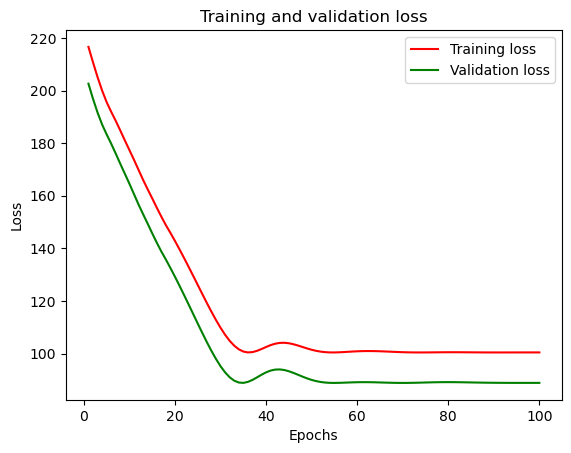

In [7]:
def rmse(y_true, y_pred):
    return torch.sqrt(F.mse_loss(y_pred, y_true))
    
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

loss_function = rmse
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
        print('Epoch [{}/{}], val Loss: {:.4f}'.format(epoch+1, 100, val_loss.item()))

# Test model
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = loss_function(test_outputs, y_test_tensor)

test_time = time.time() - start_time

print('Test loss:', test_loss.item())
print('Model testing time:', test_time)

# Plot loss over epochs
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'red', label='Training loss')
plt.plot(epochs, val_losses, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
